In [27]:
import pandas as pd
import numpy as np
from scipy.stats import skew
from numpy import median,mean
import math
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.cross_validation import cross_val_score
from sklearn import linear_model,feature_selection,metrics
from sklearn.linear_model import Lasso

In [134]:
train_data = pd.read_csv('train.csv')
train_data = train_data[(train_data['Id']!= 121) & (train_data['Id']!= 272) & (train_data['Id']!= 1276) & (train_data['Id']!= 1299)]
test_data = pd.read_csv('test.csv')
#test_data.info()

### Chekpoints for testing after Preprocessing (Rank Check)
* After imputing NAs in continuous vars and bucketing categorical vars with high cardinality wrt train - House price. Create dummies for Cat vars
* Model with sum of all sqft
* Remove skewness>.75 from all continuous vars by taking log
* Feature Engineering if Any
* Lasso Reg for feature selection
* Using Vars we get from Lasso and run Linear Reg
* To reduce the Generalization error and cover more unseen data combine Test and train features

## Data Exploration

In [29]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456 entries, 0 to 1459
Data columns (total 81 columns):
Id               1456 non-null int64
MSSubClass       1456 non-null int64
MSZoning         1456 non-null object
LotFrontage      1198 non-null float64
LotArea          1456 non-null int64
Street           1456 non-null object
Alley            91 non-null object
LotShape         1456 non-null object
LandContour      1456 non-null object
Utilities        1456 non-null object
LotConfig        1456 non-null object
LandSlope        1456 non-null object
Neighborhood     1456 non-null object
Condition1       1456 non-null object
Condition2       1456 non-null object
BldgType         1456 non-null object
HouseStyle       1456 non-null object
OverallQual      1456 non-null int64
OverallCond      1456 non-null int64
YearBuilt        1456 non-null int64
YearRemodAdd     1456 non-null int64
RoofStyle        1456 non-null object
RoofMatl         1456 non-null object
Exterior1st      1456 non-n

In [283]:
train_data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1456.000000,1456.000000,1198.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1448.000000,1456.000000,...,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000
mean,730.468407,56.881868,69.823873,10452.458791,6.096841,5.575549,1971.271978,1984.870879,103.030387,440.031593,...,94.300824,46.498626,22.014423,3.329670,15.102335,2.436813,43.608516,6.324176,2007.817308,180924.756868
std,421.209246,42.334324,23.266676,9863.741881,1.380608,1.113395,30.219453,20.633702,179.946453,435.617571,...,125.422536,65.975514,61.192248,29.168897,55.828405,38.236092,496.799265,2.701277,1.328877,79525.542842
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,366.750000,20.000000,59.000000,7538.750000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129900.000000
50%,730.500000,50.000000,69.000000,9468.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1094.250000,70.000000,80.000000,11600.000000,7.000000,6.000000,2000.000000,2004.000000,165.250000,712.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,2260.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [284]:
train_data.columns

Index([u'Id', u'MSSubClass', u'MSZoning', u'LotFrontage', u'LotArea',
       u'Street', u'Alley', u'LotShape', u'LandContour', u'Utilities',
       u'LotConfig', u'LandSlope', u'Neighborhood', u'Condition1',
       u'Condition2', u'BldgType', u'HouseStyle', u'OverallQual',
       u'OverallCond', u'YearBuilt', u'YearRemodAdd', u'RoofStyle',
       u'RoofMatl', u'Exterior1st', u'Exterior2nd', u'MasVnrType',
       u'MasVnrArea', u'ExterQual', u'ExterCond', u'Foundation', u'BsmtQual',
       u'BsmtCond', u'BsmtExposure', u'BsmtFinType1', u'BsmtFinSF1',
       u'BsmtFinType2', u'BsmtFinSF2', u'BsmtUnfSF', u'TotalBsmtSF',
       u'Heating', u'HeatingQC', u'CentralAir', u'Electrical', u'1stFlrSF',
       u'2ndFlrSF', u'LowQualFinSF', u'GrLivArea', u'BsmtFullBath',
       u'BsmtHalfBath', u'FullBath', u'HalfBath', u'BedroomAbvGr',
       u'KitchenAbvGr', u'KitchenQual', u'TotRmsAbvGrd', u'Functional',
       u'Fireplaces', u'FireplaceQu', u'GarageType', u'GarageYrBlt',
       u'GarageFinish',

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
print("Housing Price Stats:\n")
print(train_data['SalePrice'].describe())
print("\nThe median of the Housing Price is: ", train_data['SalePrice'].median(axis = 0))

Housing Price Stats:

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64
('\nThe median of the Housing Price is: ', 163000.0)


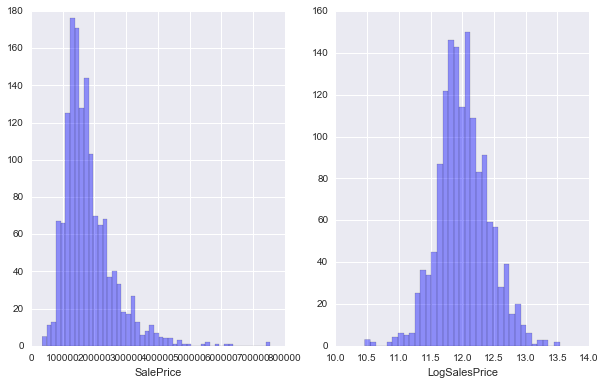

In [135]:
train_data['LogSalesPrice'] = np.log(train_data['SalePrice']+1)
f,axs = plt.subplots(1,2,figsize = (10,6))
sns.distplot(train_data['SalePrice'],kde = False,color= 'b',ax=axs[0])
sns.distplot(train_data['LogSalesPrice'],kde = False,color= 'b',ax=axs[1])  ## Will use log of sales as it makes the distribution normal

### Exploring Correlation

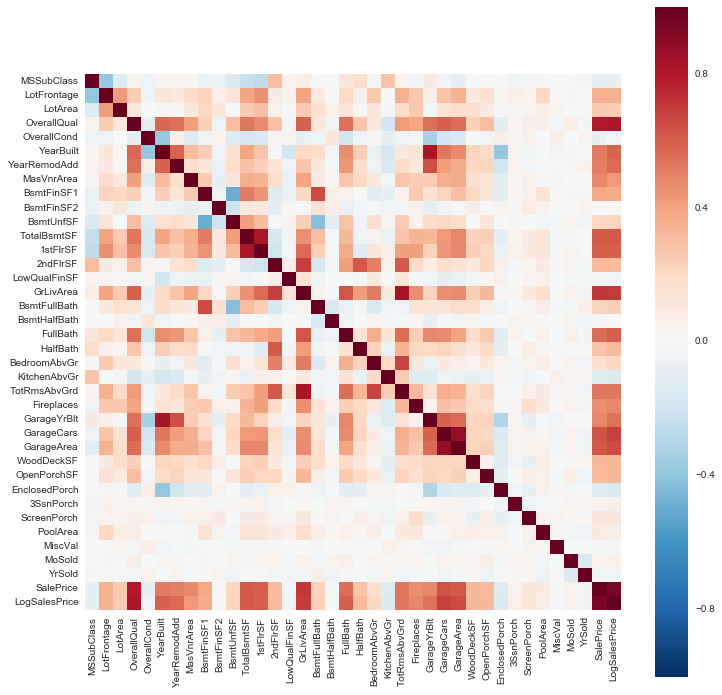

In [9]:
#select_dtypes selects columns of a type
#iloc for index search
corr = train_data.select_dtypes(include = ['float64', 'int64']).iloc[:, 1:].corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr, vmax=1, square=True)
plt.savefig("output.png")
#print corr

In [107]:
#corr
#corr.to_csv('corr.csv')

## Set .45 as threshold for High Corr. Create Plot for 
* <B> OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,     TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea





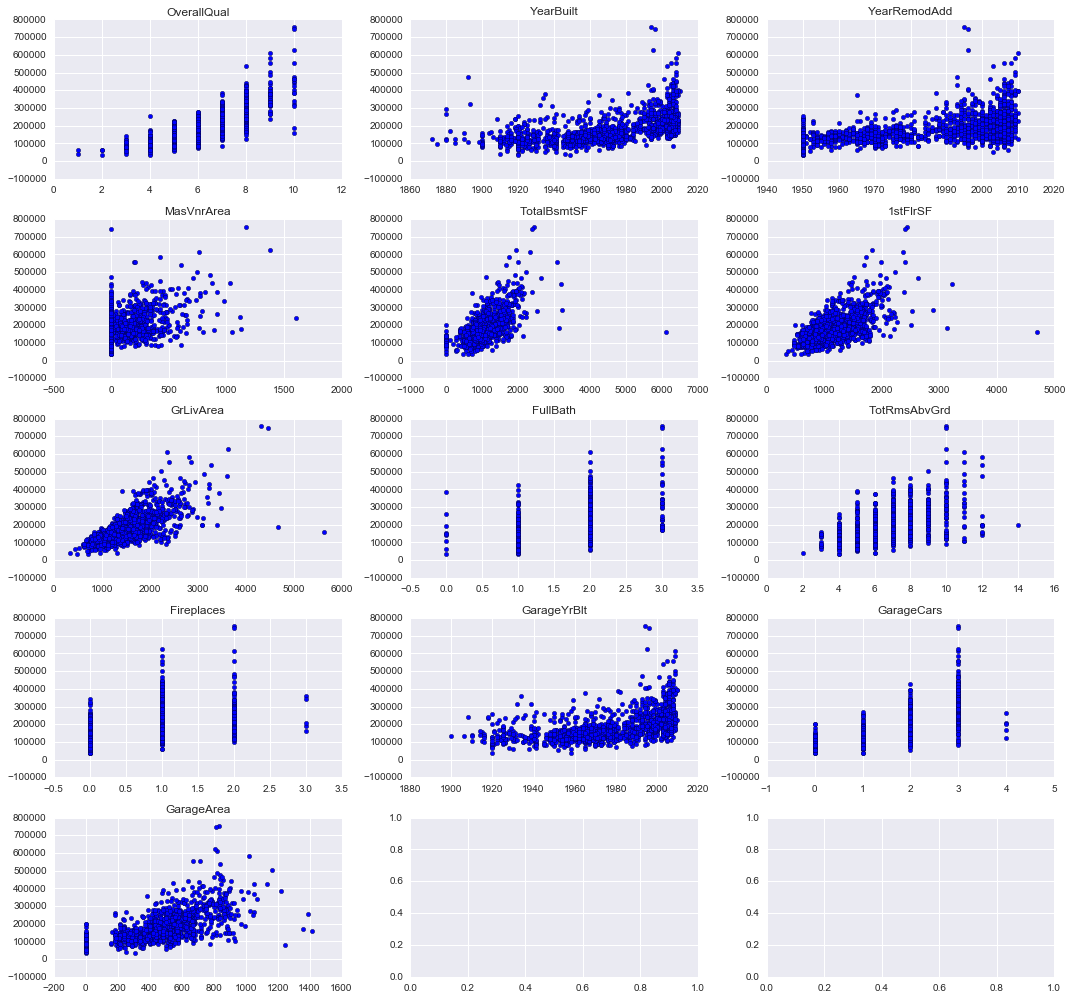

In [10]:
plt.figure(1)
f, axarr = plt.subplots(5, 3, figsize=(15, 14))
price = train_data['SalePrice']
features = ['OverallQual','YearBuilt','YearRemodAdd','MasVnrArea','TotalBsmtSF','1stFlrSF',
            'GrLivArea','FullBath','TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars','GarageArea']
i=0
j=0
for feature in features:
    axarr[i, j].scatter(train_data[feature], price)
    axarr[i, j].set_title(feature)
    if j==2:
        i=i+1
        j=0
    else:
        j=j+1
plt.tight_layout()


## Catagorical Variables
### Univariate Analysis

In [12]:
cat_var= train_data.select_dtypes(include = ['object']).columns.values

In [13]:
## Function for plots for Categorical Vals
def plotter(feature):
    f, axarr = plt.subplots(1, 3, figsize=(14, 6)) 
    sns.boxplot(x = feature, y = 'SalePrice',  data = train_data,ax=axarr[0])
    axarr[0].set_title('BOXPLOT')
    sns.barplot(x=feature, y="SalePrice",  data=train_data,ax=axarr[1],estimator=median)
    axarr[1].set_title('BARPLOT - MEDIAN')
    sns.barplot(x=feature, y="SalePrice",  data=train_data,ax=axarr[2],estimator=mean)
    axarr[2].set_title('BARPLOT - MEAN')
    plt.suptitle(feature,size=16,x=0,y=1)
    #plt.subplots_adjust(top=0.85)
    plt.tight_layout()
#xt = plt.xticks(rotation=45)

## Plot all categorical Vars

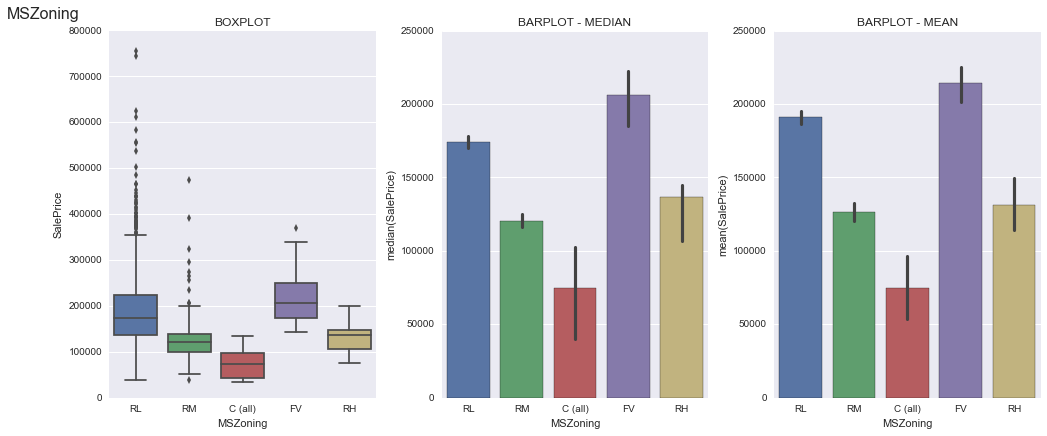

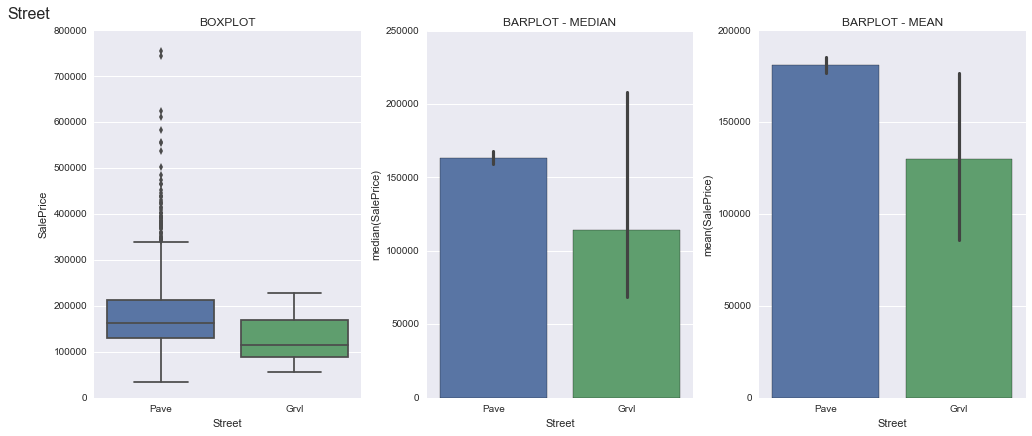

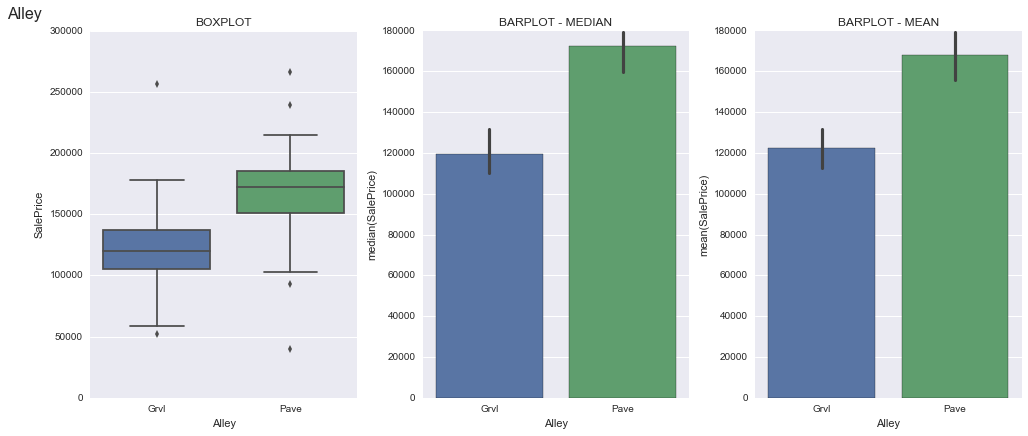

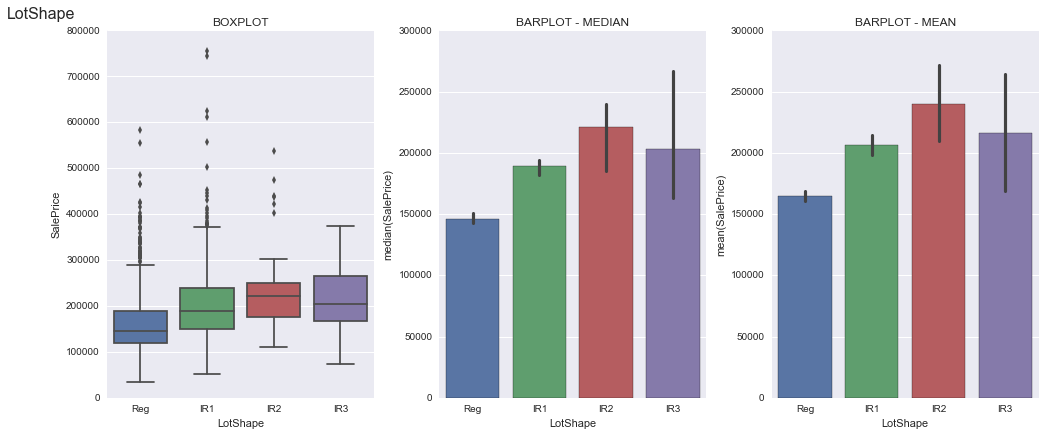

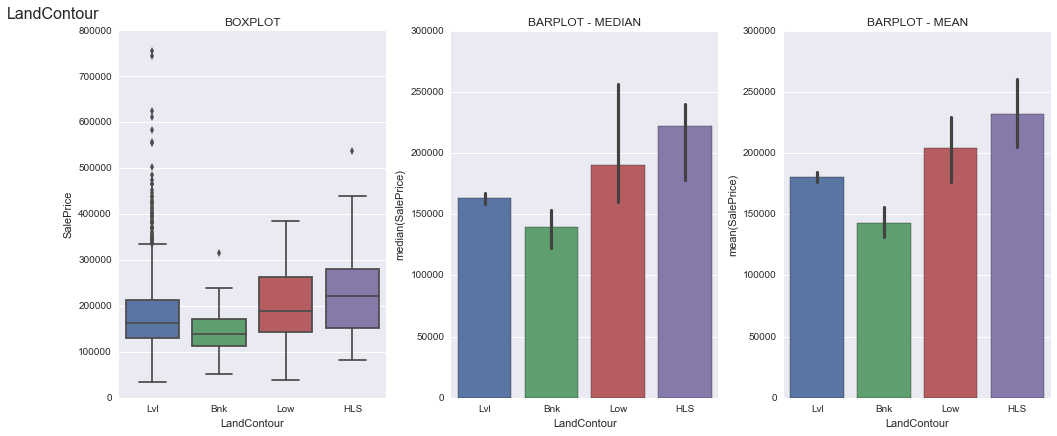

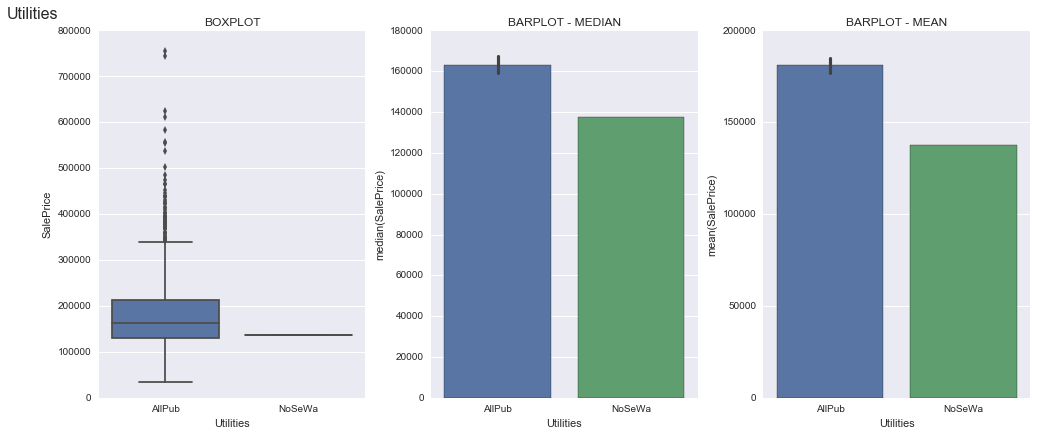

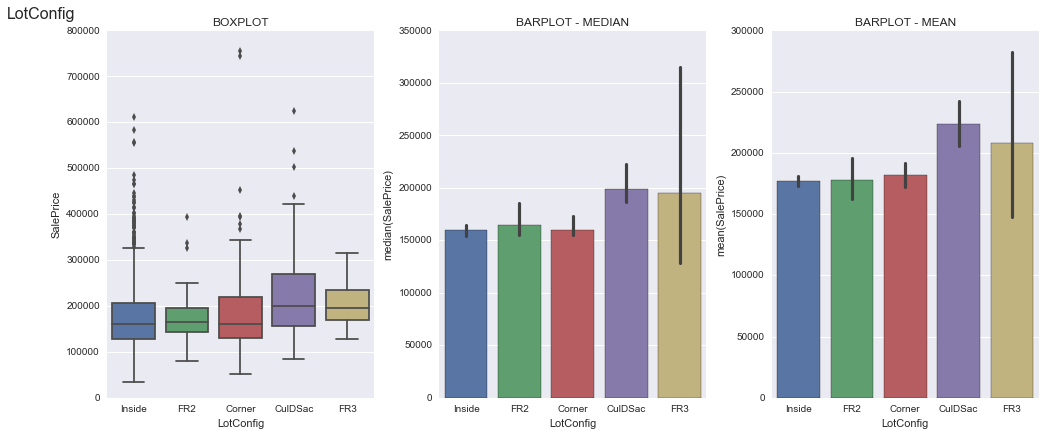

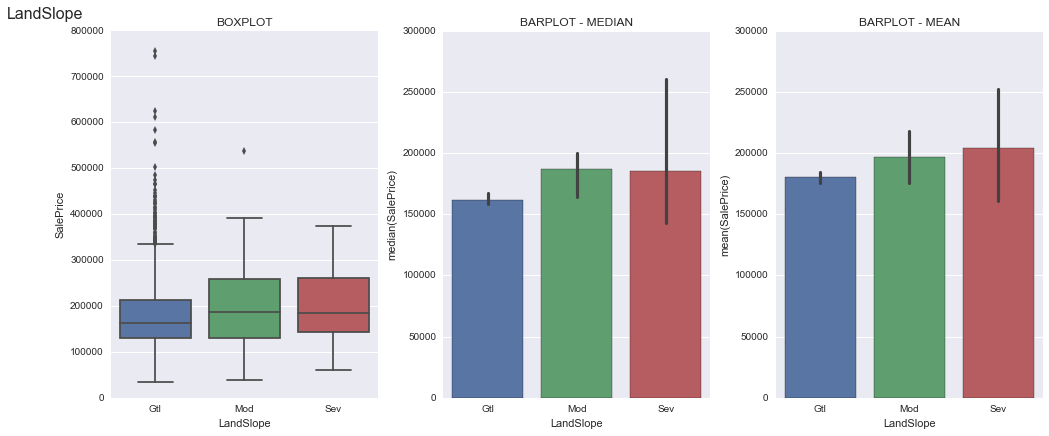

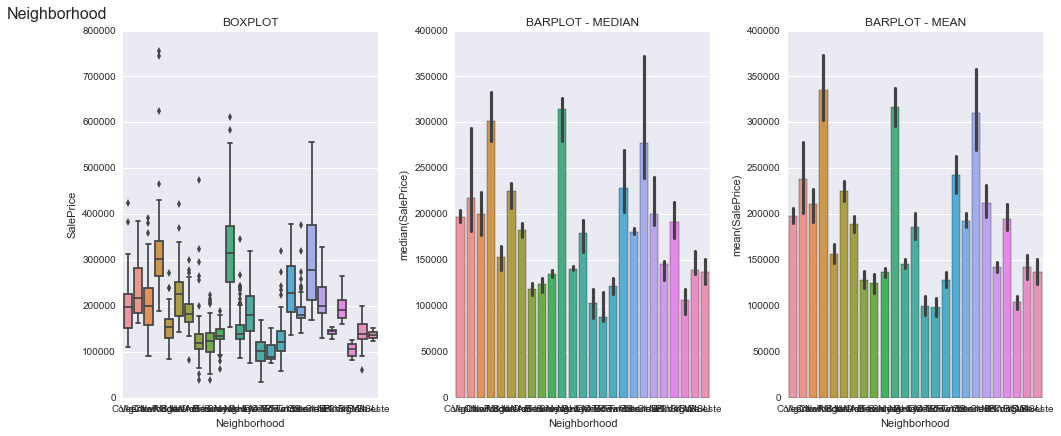

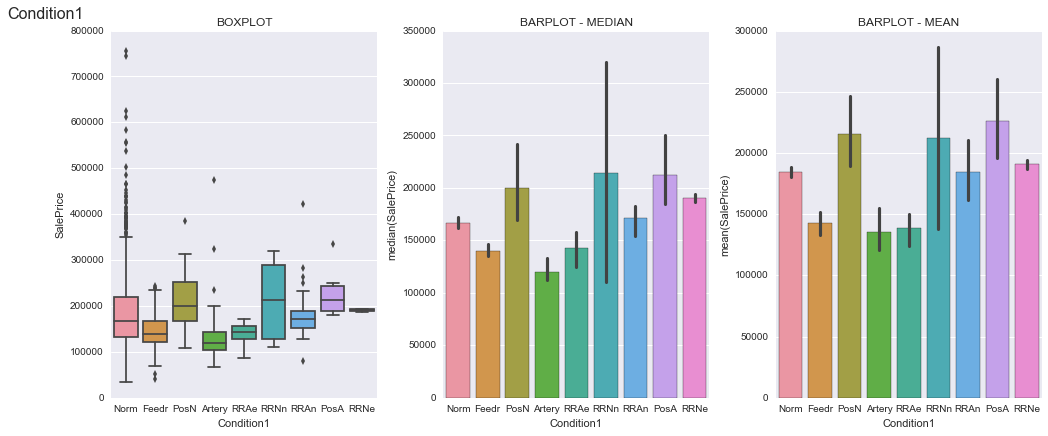

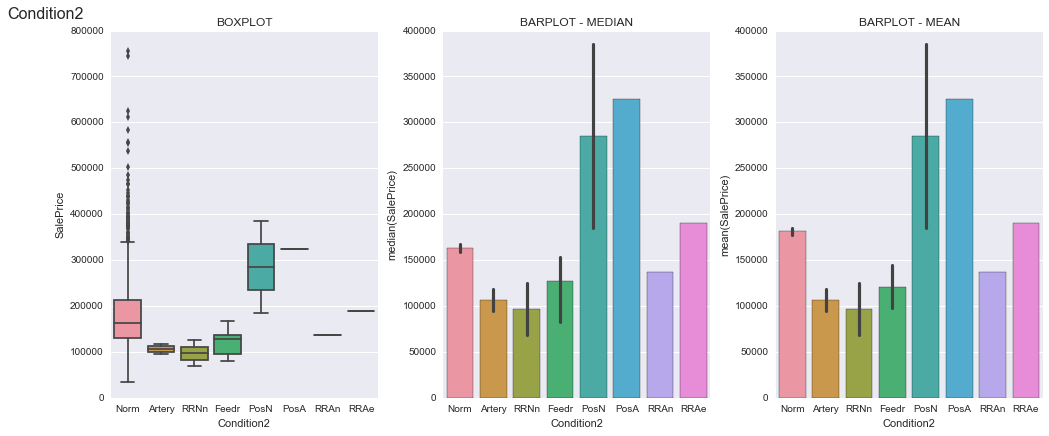

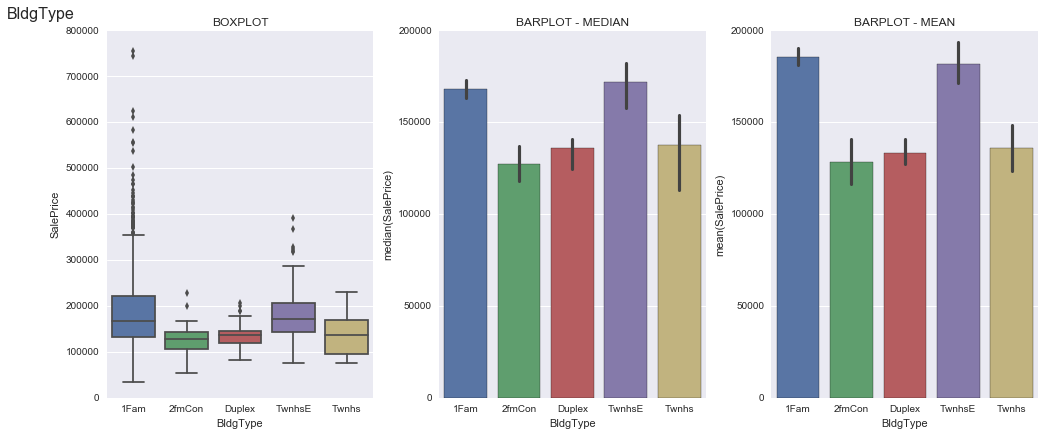

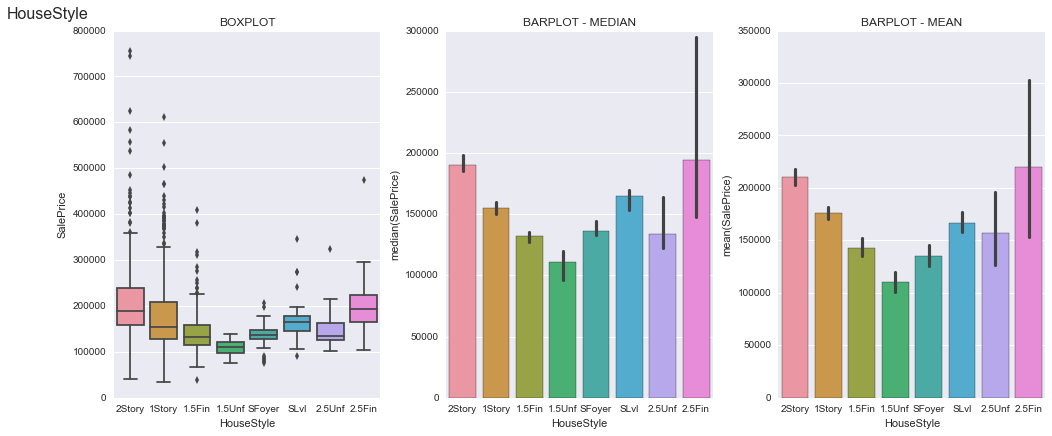

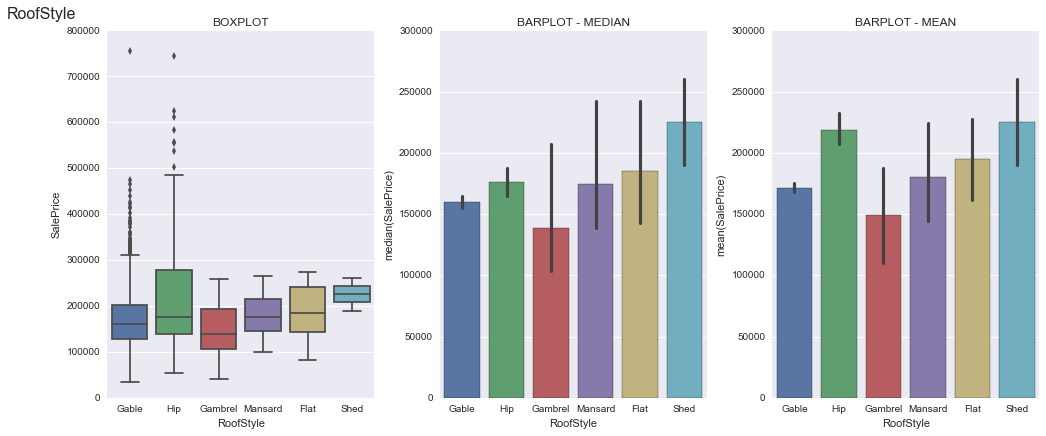

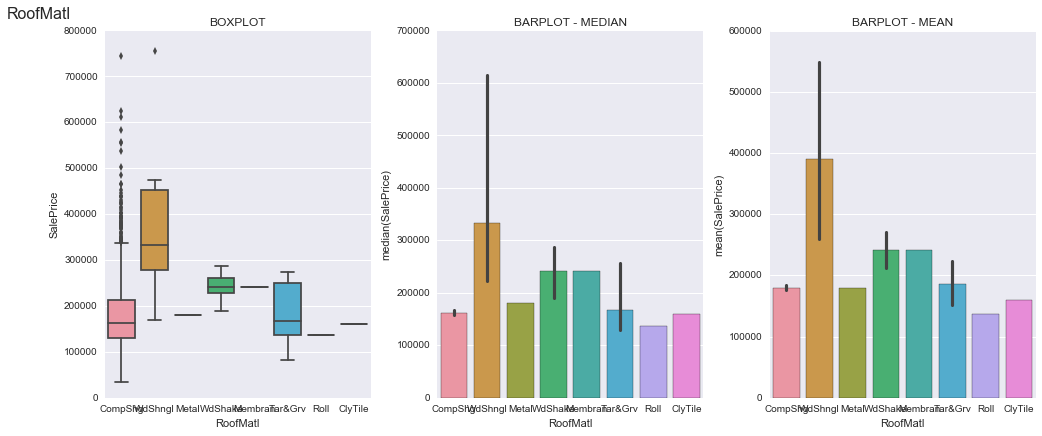

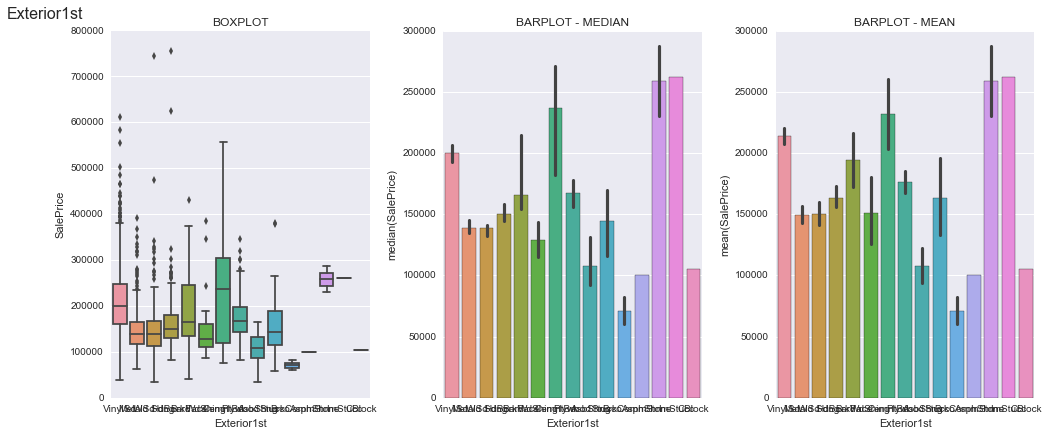

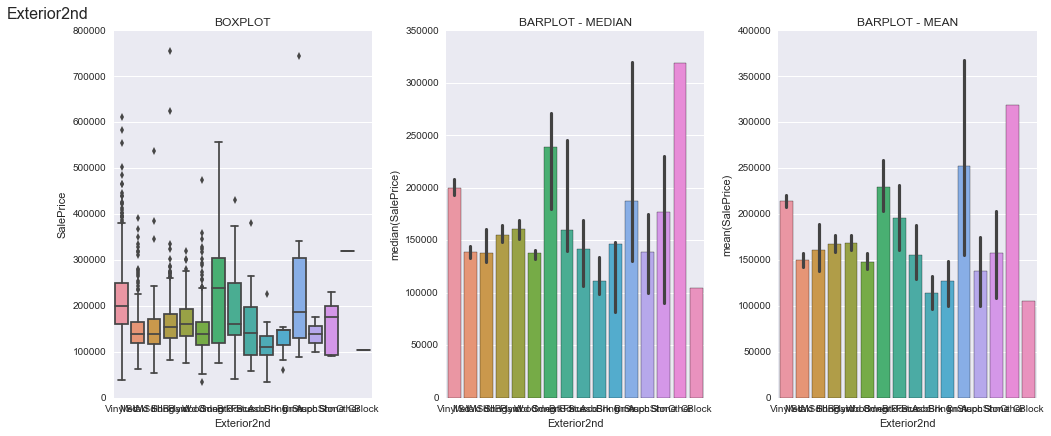

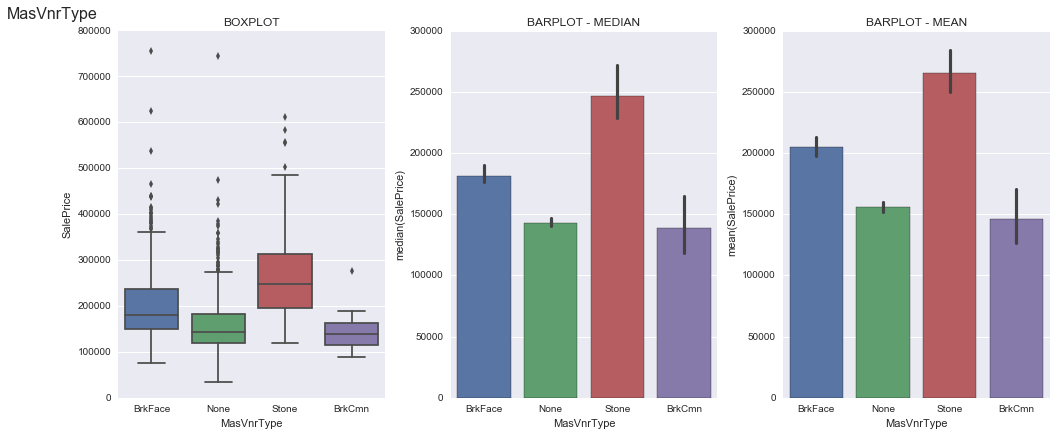

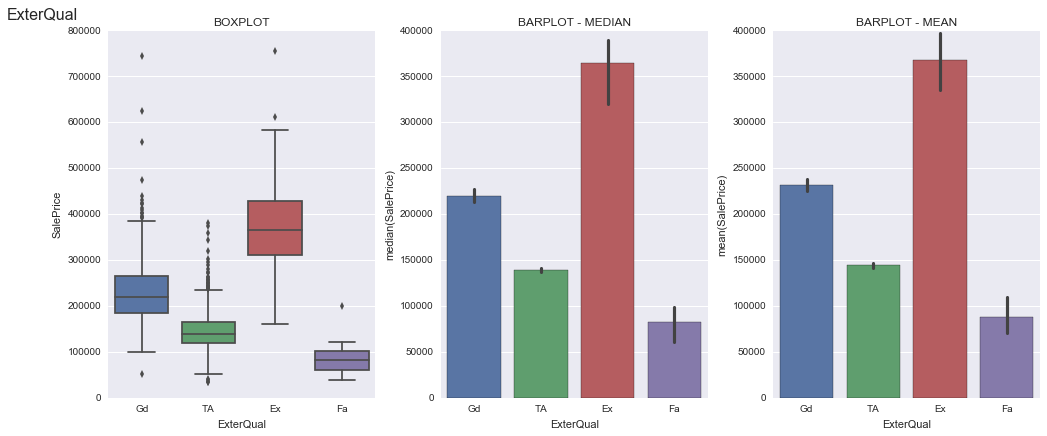

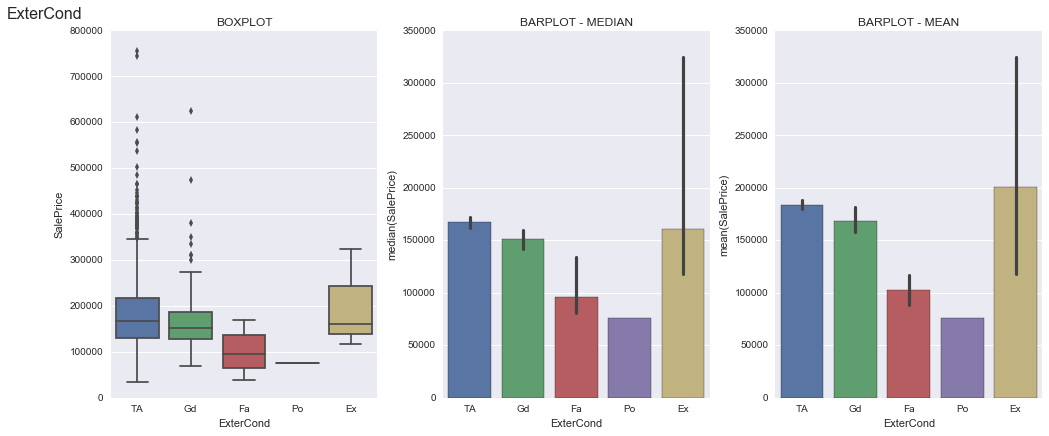

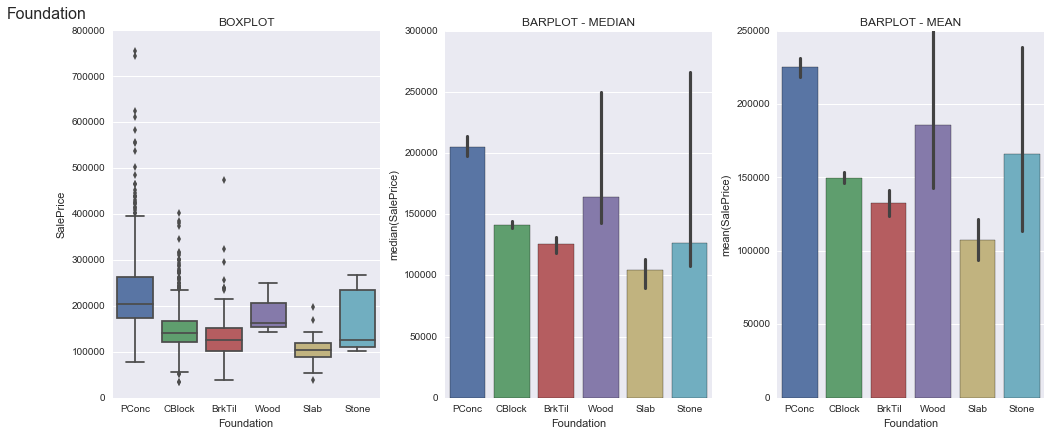

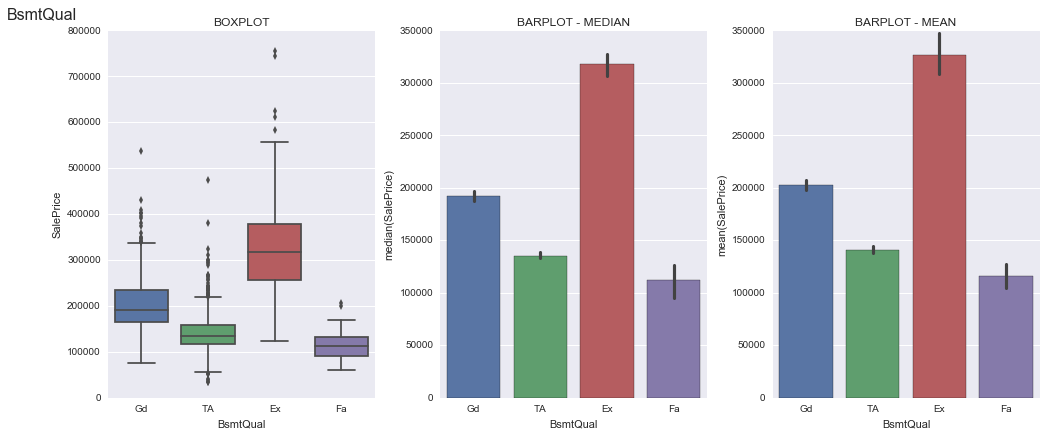

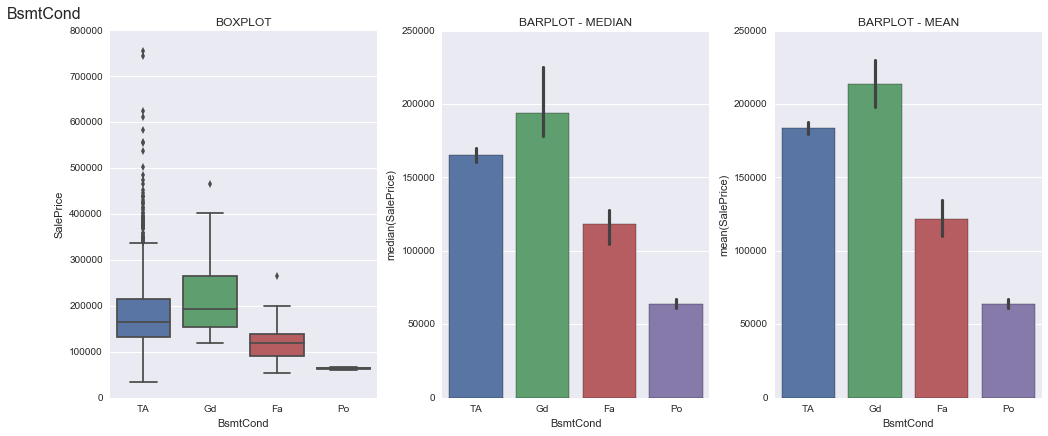

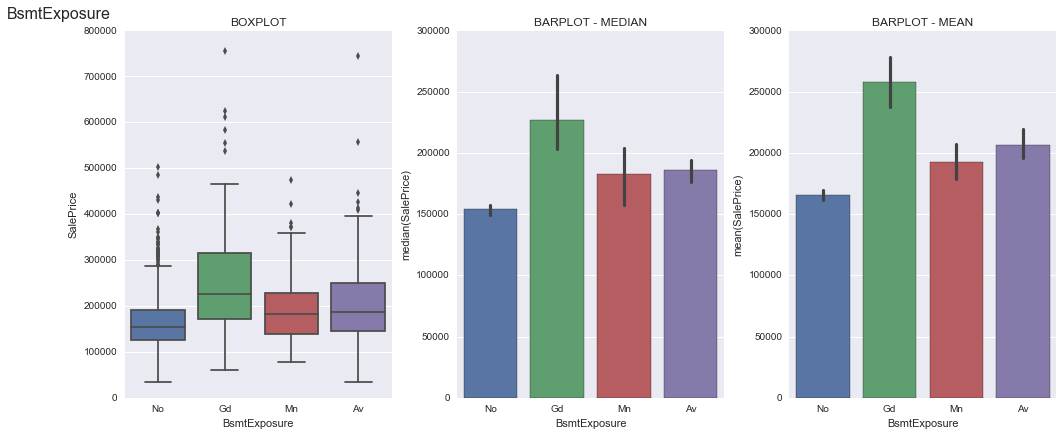

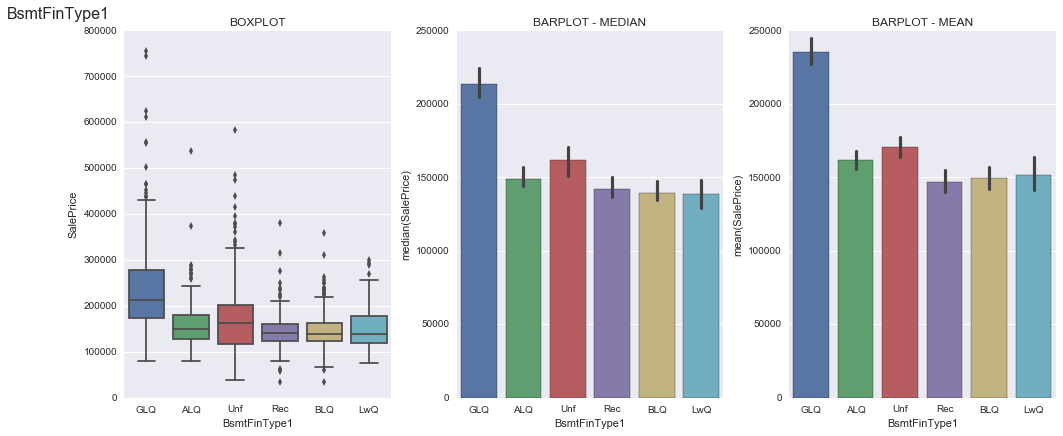

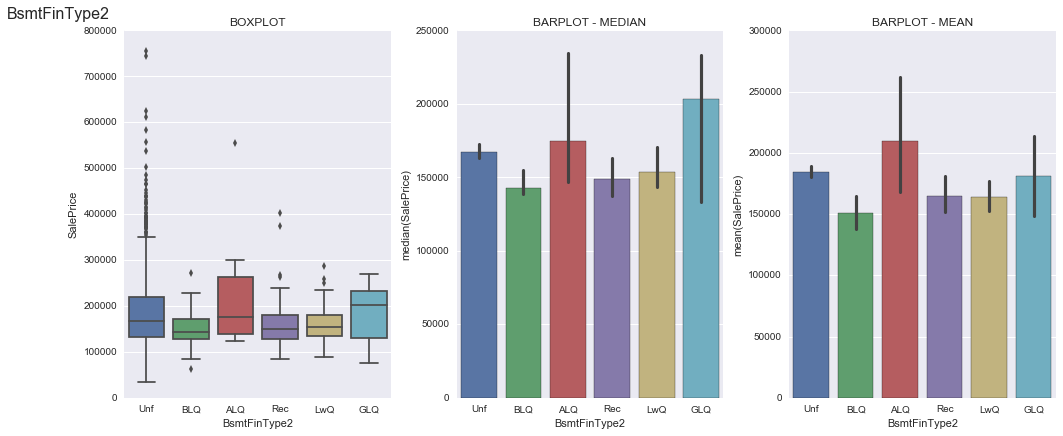

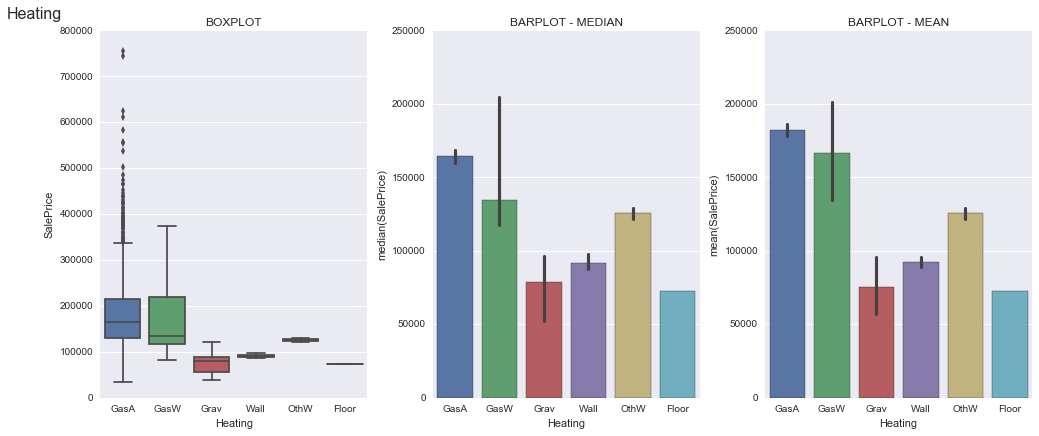

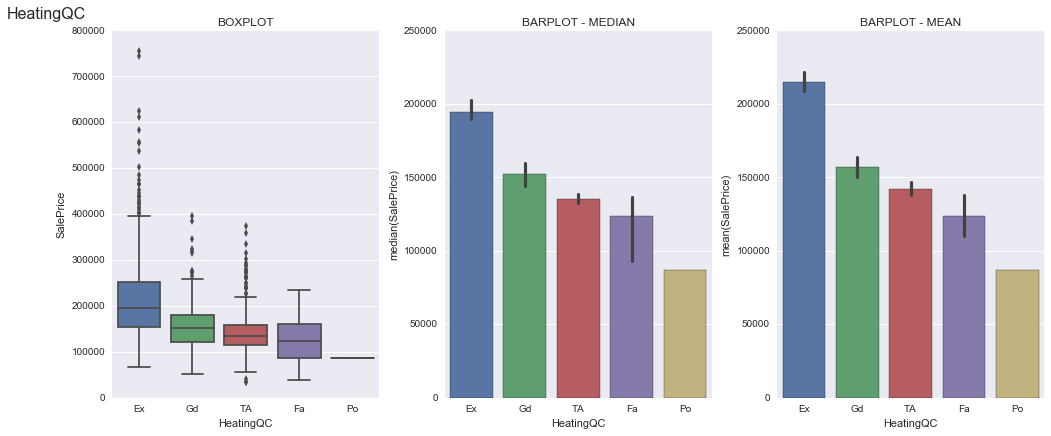

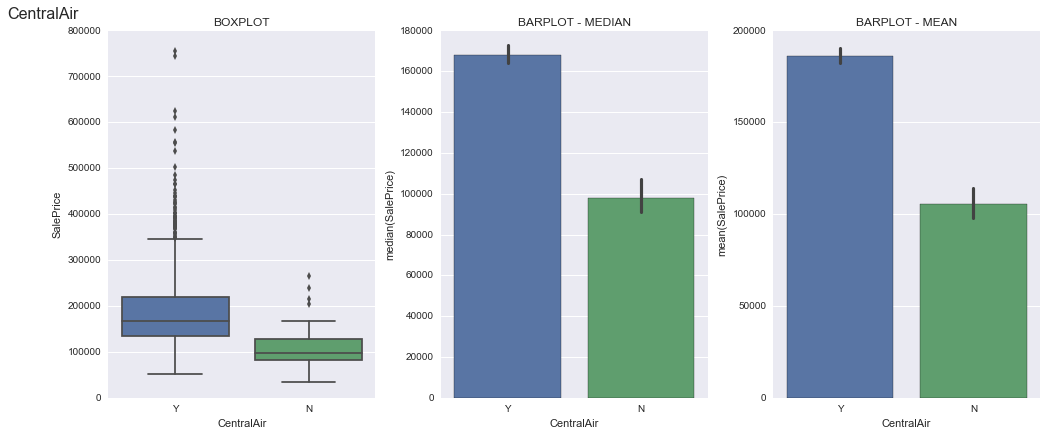

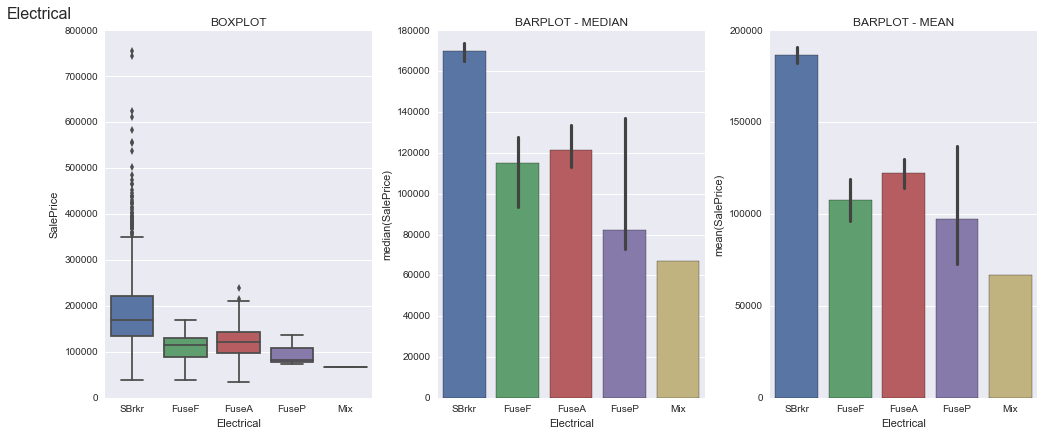

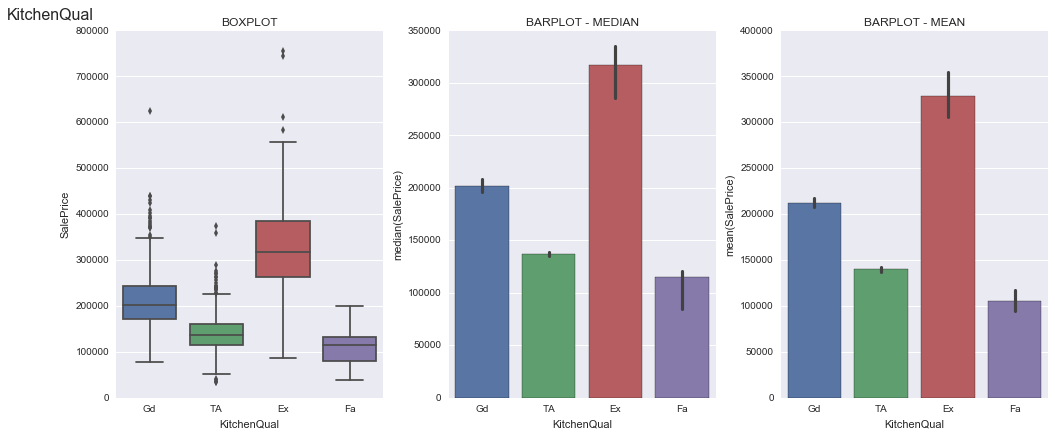

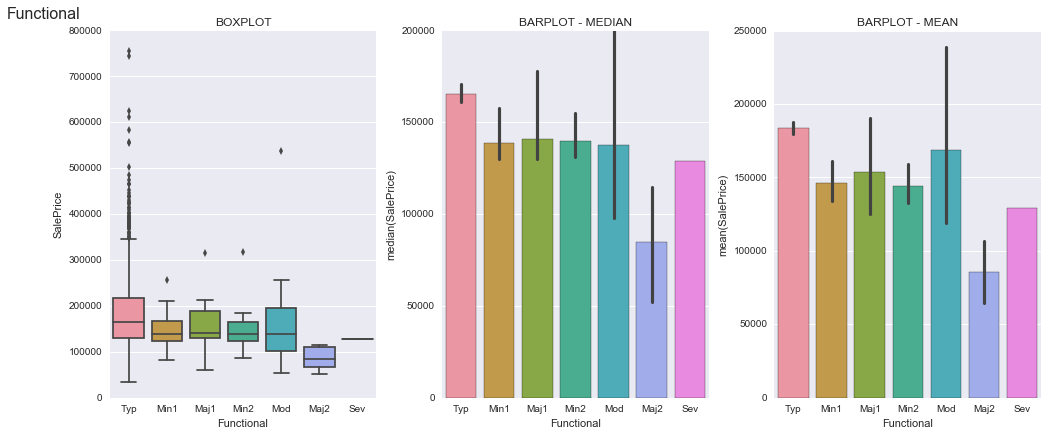

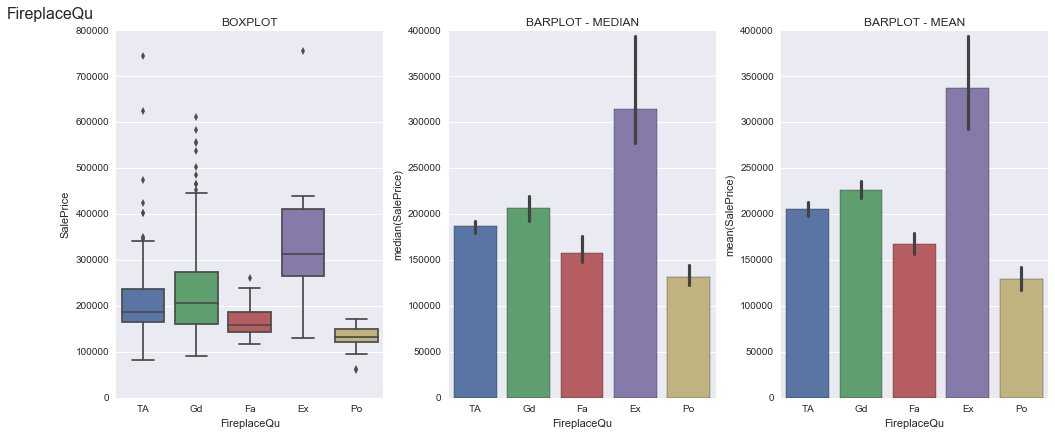

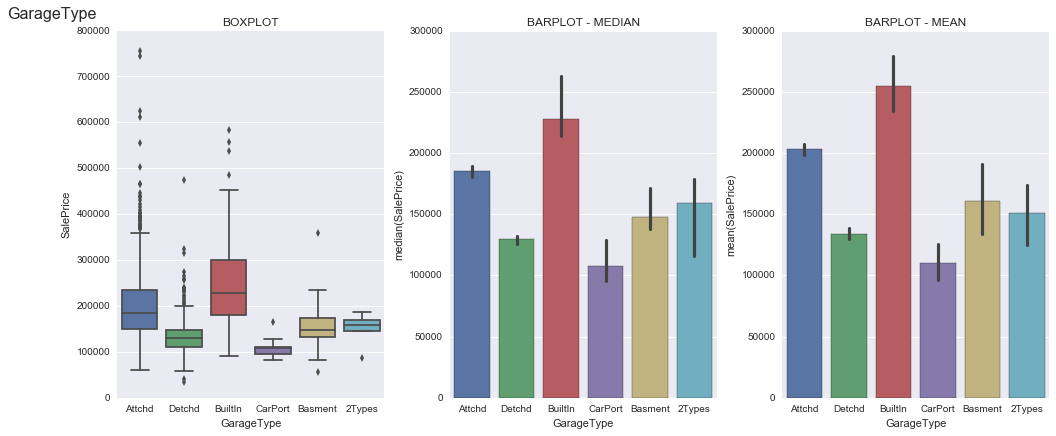

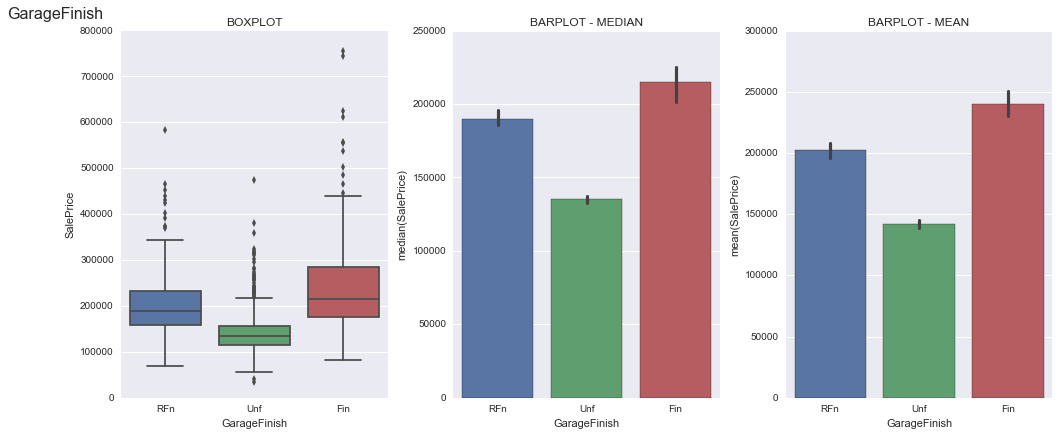

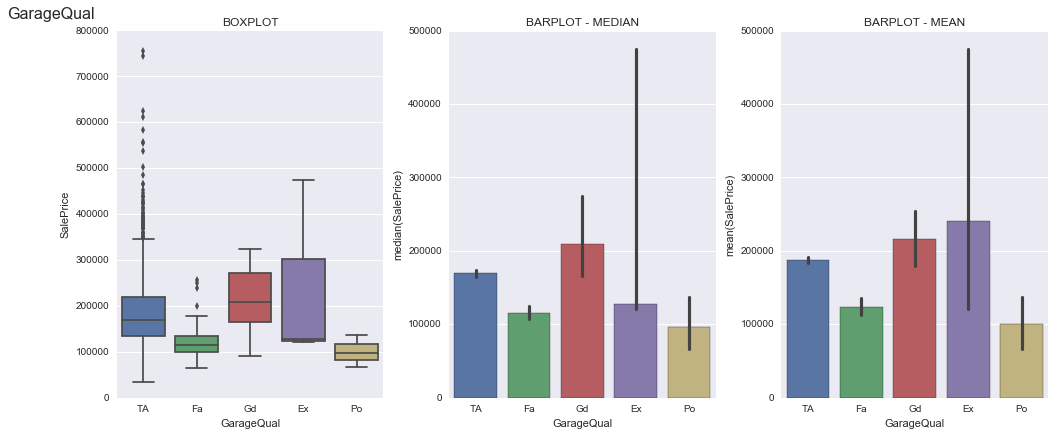

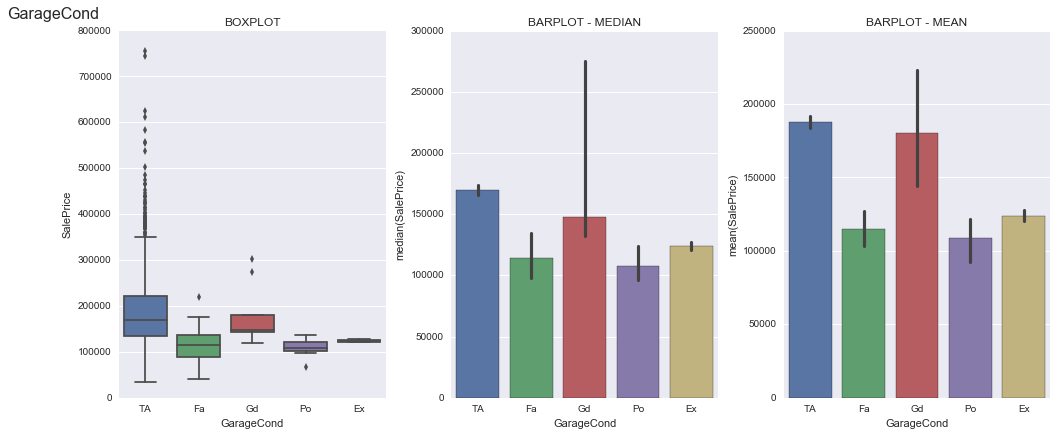

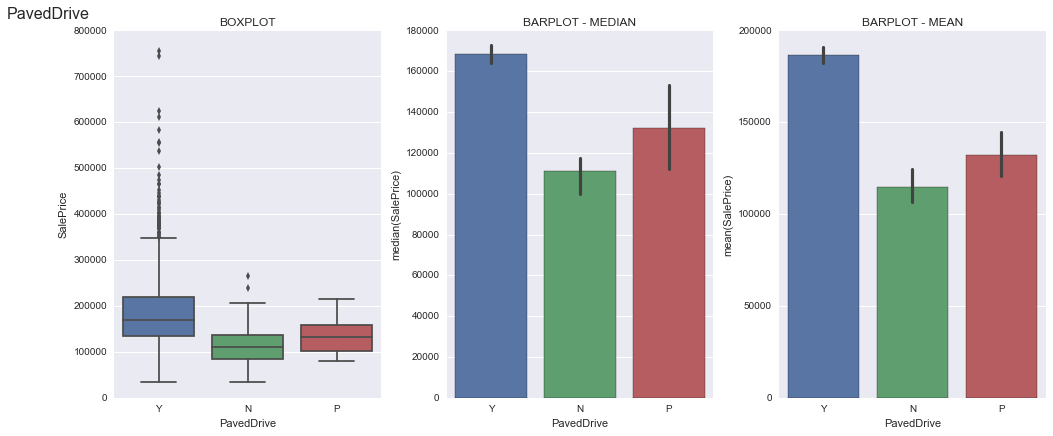

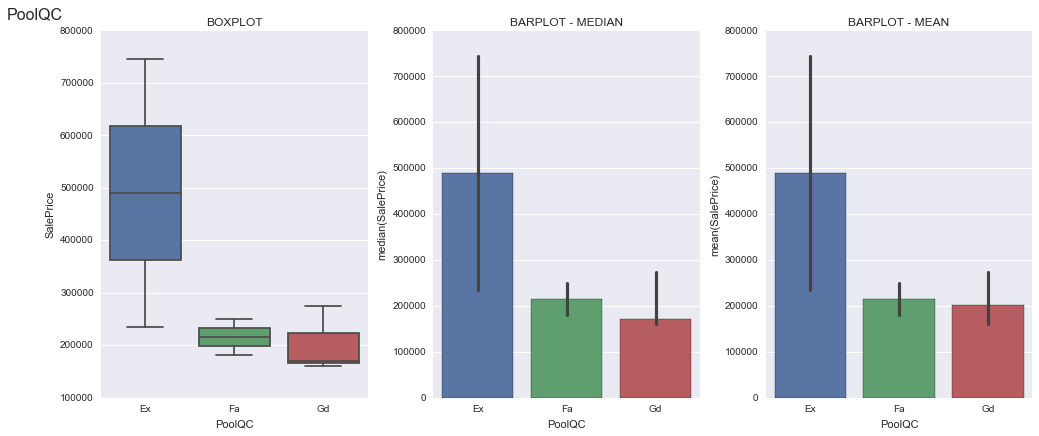

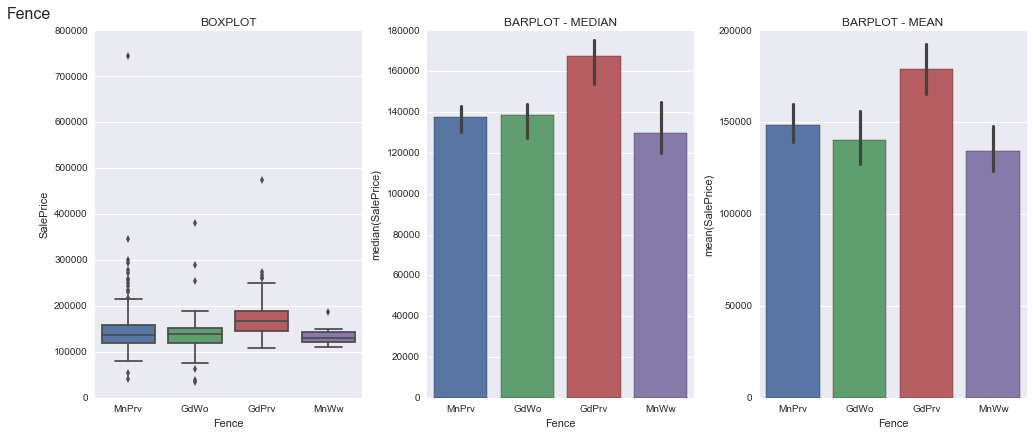

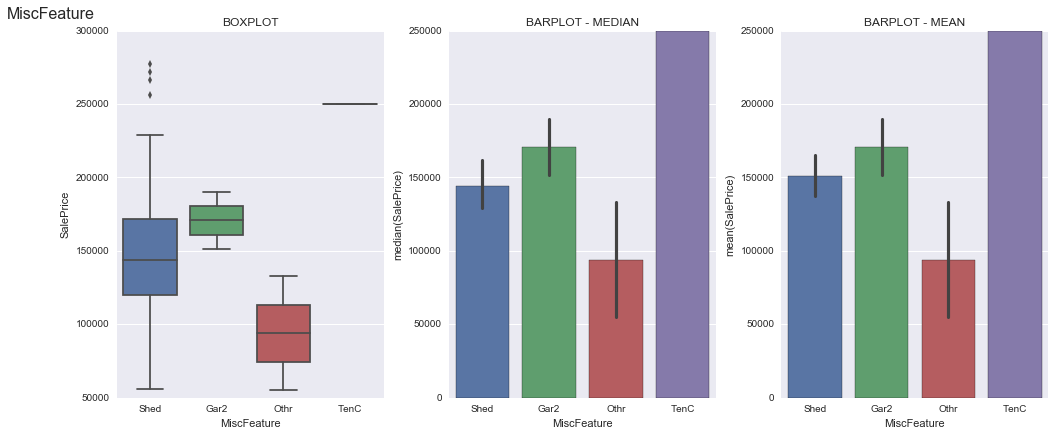

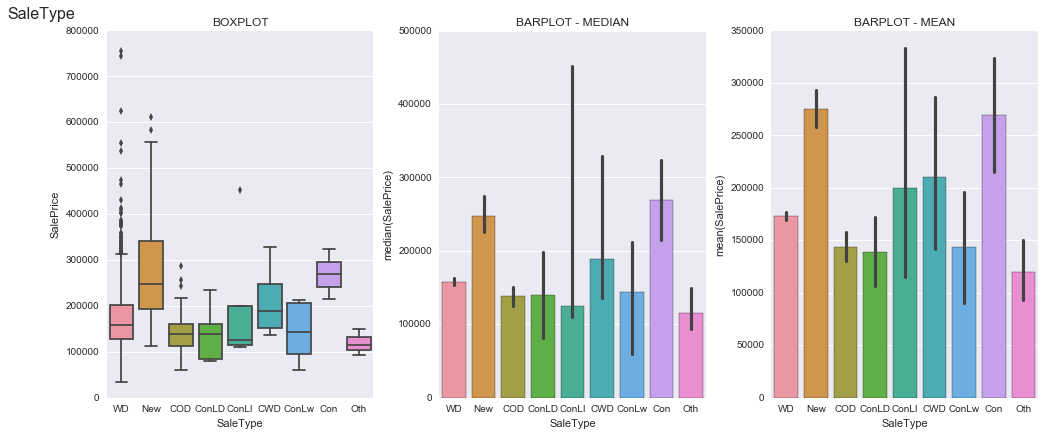

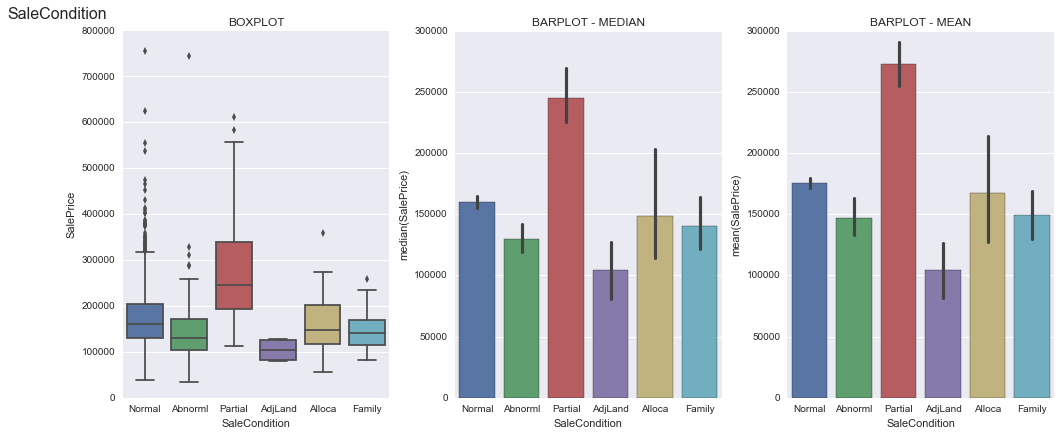

In [111]:
for i in cat_var:
    
    plotter(i)

#### Finding 1: Dims to be bucketed : Neighborhood, Exterior1st, Exterior2nd as they have high cardinality
Result : Bucketing has no effect on accuracy

In [307]:
train_data['NeighborRank'] = train_data[['Neighborhood','SalePrice']].groupby('Neighborhood').transform(lambda x: x.median())
### Bucket for Neighborhood wise median price measure : ranking
bins = []
times = 30
x = 400000/times
for i in range(times+1):
    bins.append(i*x)

group_num=range(times)

col = pd.cut(train_data['NeighborRank'],bins,labels = group_num)
#print col
train_data['NeighborRank'] = col
train_data['NeighborRank'] = (train_data['NeighborRank']).astype(int)
join_data = train_data[['Neighborhood','NeighborRank']].drop_duplicates()

###Taking it into test data
test_data = pd.merge(test_data,join_data,how='left', on = 'Neighborhood')



### Checkpoint 1 :
* Transform features with skewness>.75 by taking log
* Imputing NAs in continuous vars 
* Bucketing categorical vars with high cardinality wrt train - House price
* Create dummies for Cat vars

In [136]:
## Combine train and test for preprocessing and feature engineering. Sales Price and Log Sales Price removed from train

full_data = pd.concat([train_data.drop(['SalePrice','LogSalesPrice'],axis=1),test_data]) 


In [137]:
train_data[['MSZoning','SalePrice']].groupby('MSZoning').count()

,SalePrice
MSZoning,
C (all),10
FV,65
RH,16
RL,1147
RM,218


# Compute skewness for continuous vars and taking log for skewness >.75



In [138]:
sked = full_data.select_dtypes(include = ['int64','float64']).columns
l = len(sked)
for col in range(len(sked)):
    if skew(full_data[sked[col]].dropna())>.75:
        print sked[col] , ':', skew(full_data[sked[col]].dropna())
        full_data[sked[col]] = np.log(full_data[sked[col]]+1)


MSSubClass : 1.37622000839
LotFrontage : 1.12259025437
LotArea : 13.1152079899
MasVnrArea : 2.60919191332
BsmtFinSF1 : 0.99139123861
BsmtFinSF2 : 4.15098472997
BsmtUnfSF : 0.918924789253
1stFlrSF : 1.28072460025
2ndFlrSF : 0.863106159611
LowQualFinSF : 12.080315112
GrLivArea : 1.12835776448
BsmtHalfBath : 3.9267983022
KitchenAbvGr : 4.31721222833
TotRmsAbvGrd : 0.751774246536
WoodDeckSF : 1.84241012638
OpenPorchSF : 2.54059103458
EnclosedPorch : 4.00079639017
3SsnPorch : 11.4796542373
ScreenPorch : 3.94350811406
PoolArea : 17.6825417236
MiscVal : 21.9321469536


In [139]:
# Create Dummies
full_data =pd.get_dummies(full_data)
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2915 entries, 0 to 1458
Columns: 285 entries, Id to SaleCondition_Partial
dtypes: float64(274), int64(11)
memory usage: 6.4 MB


### Imputing Nulls

In [140]:
full_data = full_data.fillna(full_data.mean())

In [141]:
# Get Train Data
train = full_data[:train_data.shape[0]].drop(['Id','GarageYrBlt','LotShape_IR2'],axis=1) 
## These three fields are removed as they had low coef in initial run of lasso 
test = full_data[train_data.shape[0]:]
target = train_data['LogSalesPrice']


## Models

### 1. Multilinear Regression

In [168]:
reg1 = linear_model.LinearRegression()

In [96]:
def fitr(reg,data,feature,target):
    data_feature = data[feature]
    data_target = target
    reg.fit(data_feature,data_target)
    pval = feature_selection.f_regression(data_feature, data_target, center=True)
    coef = reg.coef_
    return coef,pval

In [170]:
# Features with Corr > .45
feature1 = ['OverallQual','YearBuilt','YearRemodAdd','MasVnrArea','TotalBsmtSF','1stFlrSF',
            'GrLivArea','FullBath','TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars','GarageArea']

feature2 = ['LotFrontage','BsmtFinSF1','2ndFlrSF','WoodDeckSF','OpenPorchSF']

feature3 = list(train.columns.values)
feature1=feature1+feature2
feature1 =feature3
#print feature3

In [171]:
coef_model1,pval1 = fitr(reg1,train,feature1,target)

In [172]:
for i in range(len(feature1)):
    print feature1[i],':',coef_model1[i],'    pval:',pval1[1][i]

Id : -5.4368564645e-06     pval: 0.493313824694
MSSubClass : -0.0108979464976     pval: 0.438767481378
LotFrontage : 0.0108114809378     pval: 8.95272668715e-42
LotArea : 0.0931614881101     pval: 3.46114902656e-57
OverallQual : 0.0375541460357     pval: 0.0
OverallCond : 0.0394089452888     pval: 0.159127000684
YearBuilt : 0.00176910148344     pval: 1.10363591007e-135
YearRemodAdd : 0.000826682916067     pval: 3.21168035282e-124
MasVnrArea : -9.61060516944e-05     pval: 1.2695453371e-62
BsmtFinSF1 : 0.0158820857606     pval: 9.53310241116e-16
BsmtFinSF2 : 0.00478037854152     pval: 0.246311917252
BsmtUnfSF : -0.00509933801851     pval: 9.12960402734e-16
TotalBsmtSF : 0.0946857371824     pval: 2.29624090831e-49
1stFlrSF : -0.0259689593759     pval: 6.89708360075e-149
2ndFlrSF : -0.00260696767912     pval: 3.42673989157e-12
LowQualFinSF : -0.0111556707421     pval: 0.037277123598
GrLivArea : 0.438447436569     pval: 1.60243269947e-243
BsmtFullBath : 0.0245318061126     pval: 5.791601052

In [173]:
print cross_val_score(reg1,train[feature1],target,cv=10,scoring = 'mean_squared_error').mean()

-0.0397384437437


In [174]:
test['SalePrice'] = reg1.predict(test[feature1])

C:\Users\PolestarEmployee\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [175]:
test['SalePrice'] = test['SalePrice'].apply(lambda x: math.exp(x))
submission = test[['Id','SalePrice']]

C:\Users\PolestarEmployee\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [176]:
submission.to_csv('submission.csv',index=False)

### 2. Ridge regression

In [14]:
def cv_score(model):
    return cross_val_score(model,train,target,cv=10,scoring = 'mean_squared_error').mean()

In [216]:
alpha = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
mse = []
for i in alpha:
    mse.append(-cv_score(Ridge(alpha=i)))

In [217]:
series = pd.Series(mse,alpha)

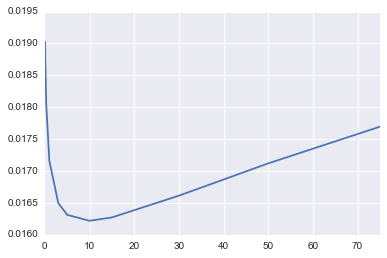

In [218]:
series.plot()

### alpha = 10 gives us minimum mse

In [219]:
series.min()

0.016219823557718671

#### For Ridge we get mse of .016

In [220]:
## Fitting Ridge with alpha =10
reg2 = Ridge(alpha = 10)
reg2.fit(train,target)

Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [221]:
test['SalePrice'] = reg2.predict(test[list(train.columns.values)])
test['SalePrice'] = test['SalePrice'].apply(lambda x : math.exp(x))

C:\Users\PolestarEmployee\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\PolestarEmployee\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [222]:
submission = test[['Id','SalePrice']]
submission.to_csv('submission.csv',index=False)

### 3. Lasso Regrssion

In [142]:
model_lasso = LassoCV(alphas = [5,1, 0.1, 0.001, 0.0005]).fit(train, target)

In [143]:
cv_score(model_lasso)

-0.013701544482317946

In [144]:
alpha_lasso = [0,0.00005,0.0001,.0002,.0003,.0005,.001]
lasso_mse = []
for i in alpha_lasso:
    lasso_mse.append(-cv_score(Lasso(i)))
lasso_ser = pd.Series(lasso_mse,alpha_lasso)

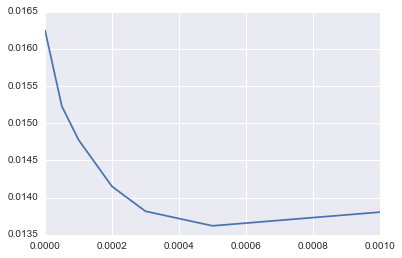

In [145]:
lasso_ser.plot()

### We get min mse at alpha = .0005

In [146]:
reg3 = Lasso(alpha = .0005)

In [147]:
reg3.fit(train,target)

Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [148]:
a = pd.Series(abs(reg3.coef_),index = list(train.columns.values))
lasso_feat = a[a>0].index

In [149]:
## Features with coeff not equal to 0
lasso_feat = list(lasso_feat) 

### Most important features according to Lasso

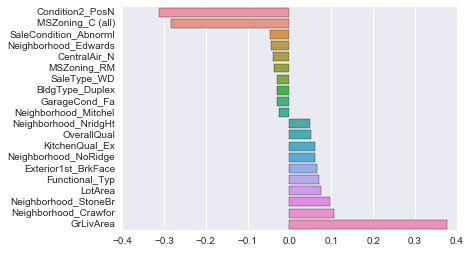

In [150]:
coef = pd.Series((reg3.coef_),index = list(train.columns.values))
coef_lasso = pd.concat([coef.sort_values().head(10),coef.sort_values().tail(10)])
sns.barplot(x=coef_lasso, y=coef_lasso.index)

In [151]:
lasso_features = train.columns.values
test['SalePrice']=reg3.predict(test[lasso_features])
test['SalePrice'] = test['SalePrice'].apply(lambda x : math.exp(x))

C:\Users\PolestarEmployee\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\PolestarEmployee\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [152]:
submission = test[['Id','SalePrice']]
submission.to_csv('submission.csv',index=False)

### 4. Using features selected by lasso with Ridge

In [30]:
train_ridge = train[lasso_feat]

In [31]:
def cv_score2(model):
    return cross_val_score(model,train_ridge,target,cv=10,scoring = 'mean_squared_error').mean()

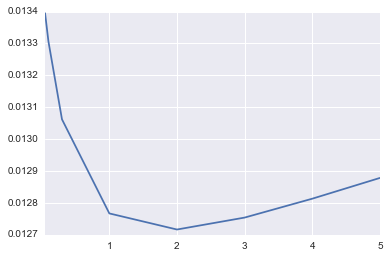

In [32]:
alpha = [0.05, 0.1, 0.3, 1,2,3,4,5]
mse2 = []
for i in alpha:
    mse2.append(-cv_score2(Ridge(alpha=i)))
series = pd.Series(mse2,alpha)
series.plot()

### alpha = 1 gives the min mse for reduced features

In [33]:
reg4 = Ridge(alpha=2)
reg4.fit(train_ridge,target)

Ridge(alpha=2, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [34]:
test['SalePrice'] = reg4.predict(test[lasso_feat])
test['SalePrice'] = test['SalePrice'].apply(lambda x : math.exp(x))

C:\Users\PolestarEmployee\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\PolestarEmployee\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [36]:
submission = test[['Id','SalePrice']]
submission.to_csv('submission.csv',index=False)

### Out of all the above, Lasso (3) gives the best performance

### 5. Running Lasso Features with Linear Regression

In [110]:
arrr = ['Id',
'OverallCond',
'BsmtFinSF2',
'YrSold',
'Alley_Pave',
'LotConfig_Corner',
'LotConfig_FR2',
'LandSlope_Mod',
'Neighborhood_Mitchel',
'Condition1_RRAe',
'Condition2_PosN',
'BldgType_TwnhsE',
'Exterior1st_BrkFace',
'Exterior2nd_Plywood',
'Heating_GasW',
'SaleCondition_Family']

lasso_new_feat = [i for i in lasso_feat if i not in arrr]

In [111]:
reg5 = linear_model.LinearRegression()
coef_model5,pval5 = fitr(reg5,train,lasso_new_feat,target)

In [112]:
for i in range(len(lasso_new_feat)):
    print lasso_new_feat[i],':',coef_model5[i],'    pval:',pval5[1][i]

LotFrontage : 0.0239201684461     pval: 1.39219570682e-42
LotArea : 0.0617040285465     pval: 1.17725042931e-57
OverallQual : 0.0517301385695     pval: 0.0
YearBuilt : 0.000392685987749     pval: 7.78397687489e-136
YearRemodAdd : 0.00169683784715     pval: 4.77270260651e-124
BsmtFinSF1 : 0.0101678430472     pval: 9.84341314566e-16
BsmtUnfSF : -0.00340640618929     pval: 5.67312446652e-16
TotalBsmtSF : 6.4795041804e-05     pval: 1.75754619671e-170
1stFlrSF : -0.0261576121499     pval: 2.6775072982e-151
2ndFlrSF : -0.0047005457703     pval: 2.40377429192e-12
LowQualFinSF : -0.0105262909136     pval: 0.0376278749149
GrLivArea : 0.445953439869     pval: 8.89296333795e-249
BsmtFullBath : 0.0261495703445     pval: 6.08304876503e-20
FullBath : 0.0263475166323     pval: 3.31645793804e-141
HalfBath : 0.0204471532412     pval: 7.14942751638e-35
KitchenAbvGr : -0.17940912966     pval: 3.67501657638e-08
Fireplaces : 0.0176630598422     pval: 1.34864277186e-89
GarageYrBlt : -0.000291424335656     p

In [113]:
print cross_val_score(reg5,train[lasso_new_feat],target,cv=10,scoring = 'mean_squared_error').mean()

-0.0141158010913


In [114]:
test['SalePrice'] = reg5.predict(test[lasso_new_feat])
test['SalePrice'] = test['SalePrice'].apply(lambda x: math.exp(x))
submission = test[['Id','SalePrice']]

C:\Users\PolestarEmployee\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\PolestarEmployee\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [115]:
submission.to_csv('submission.csv',index=False)